Splitting the data into train/val/test and saving the splits

In [ ]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path

LABELS_CSV_PATH = "../data/labels.csv"

df= pd.read_csv(LABELS_CSV_PATH)
assert not df.isna().sum().any()

with open("../data/splits_15.json", "r") as f:
    split_cases = json.load(f)

# === Assign 'split' column based on JSON ===
df['split'] = 'unassigned'
for split_name, case_list in split_cases.items():
    df.loc[df['case'].isin(case_list), 'split'] = split_name

# === 1. Show number of labeled vs. unlabeled ===

assert (df['split'] != 'unassigned').all(), "There are still frames with 'unassigned' split!"

df.head()
df.to_csv("../data/subset/labels_index_15.csv", index=False)

# Creating subsets

Loaded CSV. Head:
                                frame_path      case  part  frame_time  \
0  case_000_video_part_001/frame_00001.jpg  case_000     1           1   
1  case_000_video_part_001/frame_00002.jpg  case_000     1           2   
2  case_000_video_part_001/frame_00003.jpg  case_000     1           3   

       label  split  
0  unlabeled  train  
1  unlabeled  train  
2  unlabeled  train  
TRAIN frames total: 1,648,668
TRAIN labeled frames (no 'unlabeled'): 526,847
Unique TRAIN cases: 109 | labeled cases: 109
Detected labeled classes: ['Range of motion', 'Rectal artery/vein', 'Retraction and collision avoidance', 'Skills application', 'Suspensory ligaments', 'Suturing', 'Uterine horn']

TRAIN labeled class counts:
label
Range of motion                        13901
Rectal artery/vein                     94321
Retraction and collision avoidance     14805
Skills application                     39625
Suspensory ligaments                   61306
Suturing                           

/var/folders/n9/nq2hxlvj1dbfjrylmjc7f0m40000gn/T/ipykernel_90581/2438224794.py:87: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series(labeled_count_vec(g), index=[f"c_{i}" for i in range(K)]))



Per-case labeled counts (sample):
       case  c_0   c_1  c_2   c_3  c_4   c_5   c_6
0  case_000    0     0    0   564    0     0     0
1  case_001    0   932    0  1013  511  1038   625
2  case_002  458   880  163   878  636  3541  1223
3  case_003    0   989    0     0  280  1164   674
4  case_004  233  1644  131   694  603  1578  1058
Total TRAIN labeled frames (sum over cases): 526847

GLOBAL_LAB_FRAC (TRAIN): 0.320

======================================== Target 12p5 ========================================

Starting greedy [12p5] (best-so-far): target_labeled_sum=65856, target_total≈206083, global_lab_frac=0.320, penalty_over=3.0, alpha_unl=5.0, beta_total=3.0, patience=12
  step   1 | labeled_sum=7736/65856 | total≈16402/206083 | frac_lab=0.472 (Δ=+0.152) | mean_dev=0.921 | cost=26987.144 | best_at=1
  step   2 | labeled_sum=15671/65856 | total≈31330/206083 | frac_lab=0.500 (Δ=+0.181) | mean_dev=0.804 | cost=22928.039 | best_at=2
  step   3 | labeled_sum=24815/65856 | total≈51

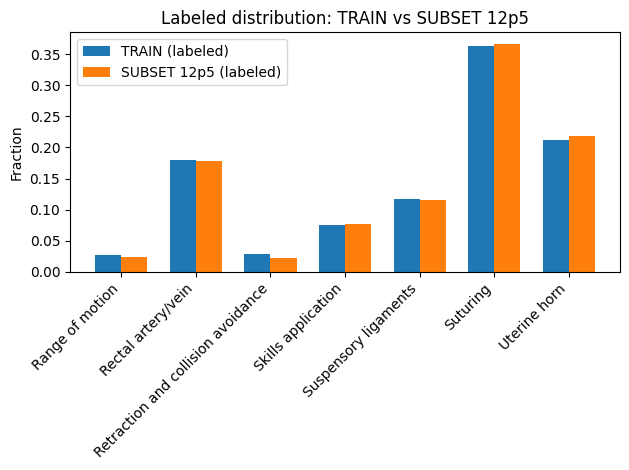

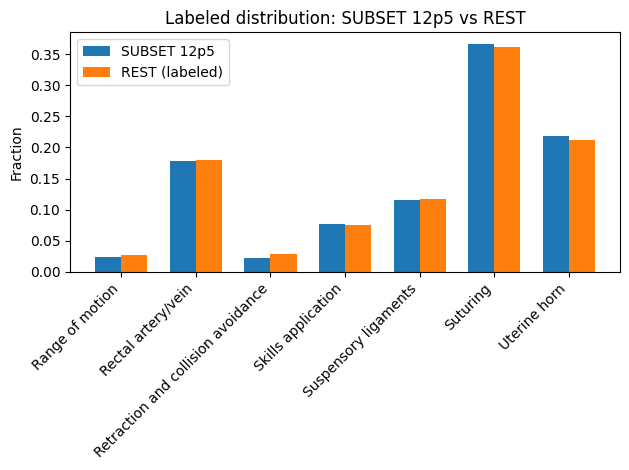

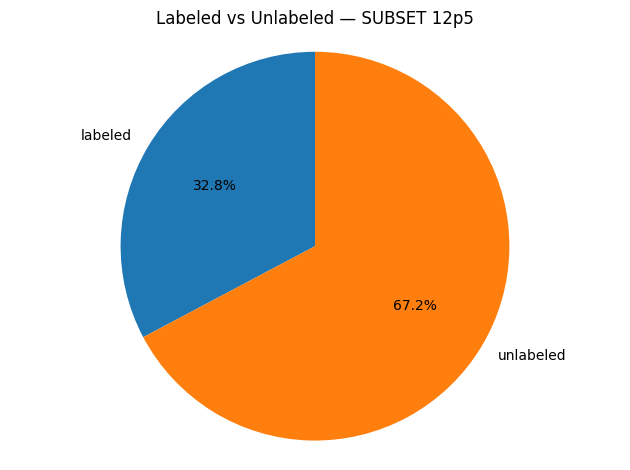

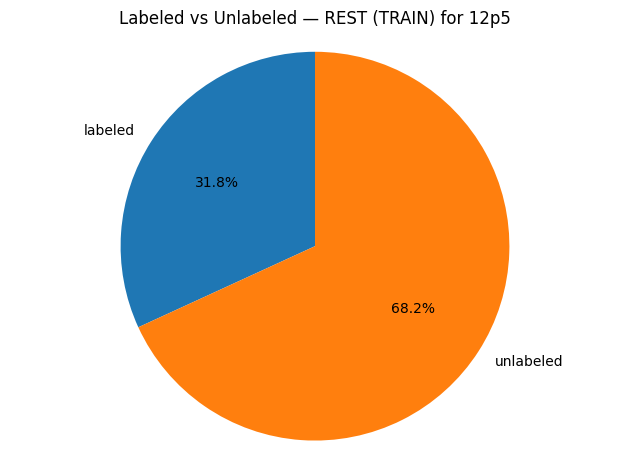


---------------- SUMMARY: subset 25 ----------------
[SUBSET 25] total=393,323 | labeled=129,278 | unlabeled=264,045 | frac_labeled=0.329
[REST   25] total=1,255,345 | labeled=397,569 | unlabeled=857,776 | frac_labeled=0.317

Labeled class fractions — TRAIN vs SUBSET:
                                    TRAIN_frac  SUBSET_25_frac
label                                                         
Range of motion                       0.026385        0.024335
Rectal artery/vein                    0.179029        0.181446
Retraction and collision avoidance    0.028101        0.026679
Skills application                    0.075212        0.074406
Suspensory ligaments                  0.116364        0.112123
Suturing                              0.362866        0.368052
Uterine horn                          0.212043        0.212960

Labeled class fractions — SUBSET vs REST:
                                    SUBSET_25_frac  REST_25_frac
label                                                  

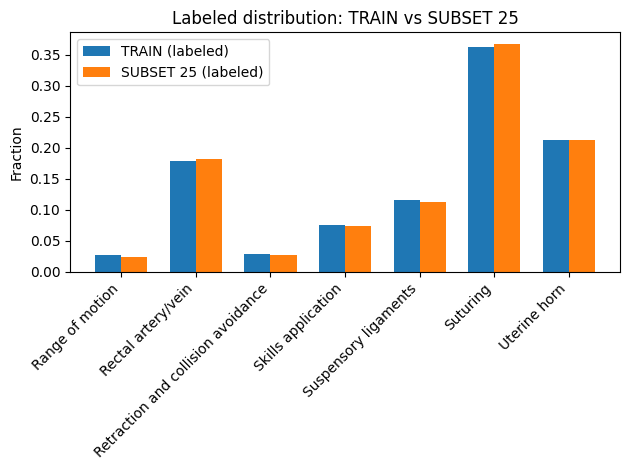

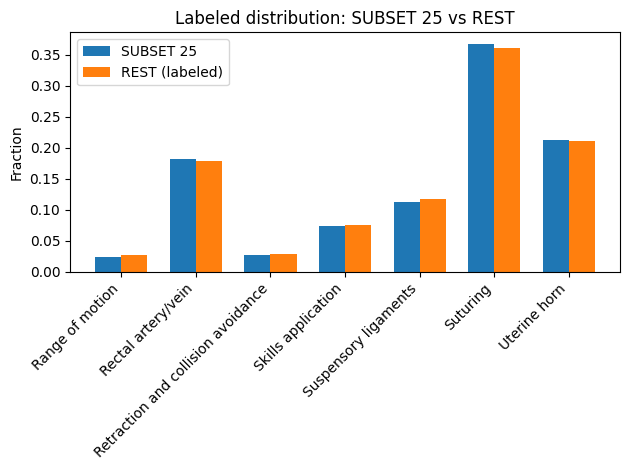

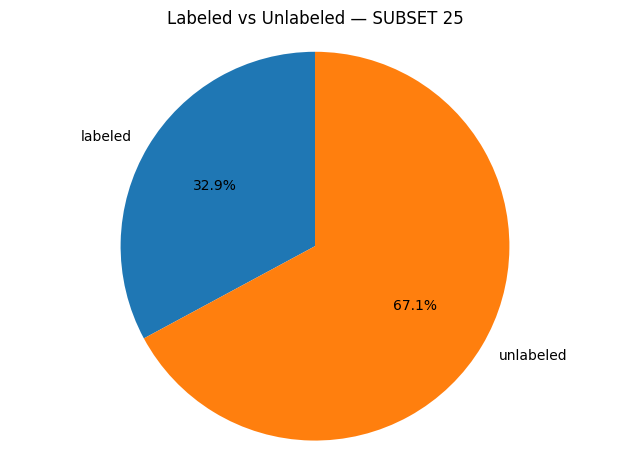

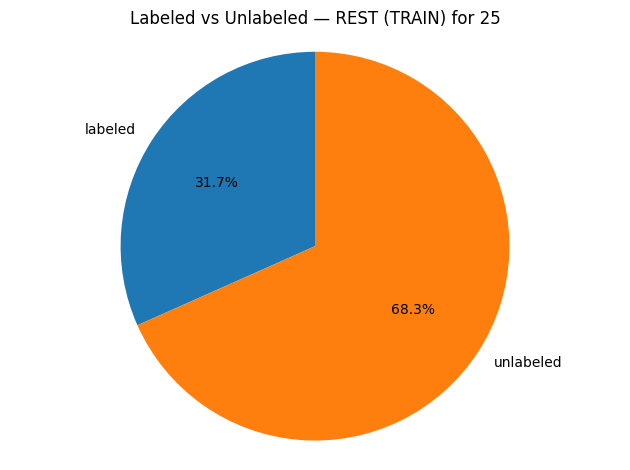


[12p5] EXPECTED total≈206,083 | GOT total=194,617 | frac_labeled=0.328 (global=0.320)

[25] EXPECTED total≈412,166 | GOT total=393,323 | frac_labeled=0.329 (global=0.320)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

CSV_PATH = "../data/labels_index_15.csv"

TARGET_FRACS = {
    "12p5": 0.125,   
    "25":   0.25,    
}

SEED = 42
PENALTY_OVER = {
    "12p5": 3.0,   # penalty for "overflowing" majority classes (labeled)
    "25":   2.2,
}

VERBOSE_EVERY = 10

ALPHA_UNL = {"12p5": 5.0, "25": 3.5}   # penalty for deviation of labeled fraction from global
BETA_TOTAL = {"12p5": 3.0, "25": 2.0}  # penalty for deviation of total frame count from expected

df = pd.read_csv(CSV_PATH)
print("Loaded CSV. Head:")
print(df.head(3))

required = {"frame_path", "case", "label", "split"}
missing = required - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}")

df["label"] = df["label"].astype(str)

df_train = df[df["split"] == "train"].copy()
if df_train.empty:
    raise ValueError("TRAIN split is empty.")

# Labeled = without 'unlabeled' and without NaN — ONLY for target and matching
df_train_lab = df_train[(df_train["label"].notna()) & (df_train["label"] != "unlabeled")].copy()
if df_train_lab.empty:
    raise ValueError("No labeled frames in TRAIN — cannot build target.")

print(f"TRAIN frames total: {len(df_train):,}")
print(f"TRAIN labeled frames (no 'unlabeled'): {len(df_train_lab):,}")
print(f"Unique TRAIN cases: {df_train['case'].nunique()} | labeled cases: {df_train_lab['case'].nunique()}")


classes = sorted(df_train_lab["label"].unique())
class2idx = {c: i for i, c in enumerate(classes)}
K = len(classes)
print("Detected labeled classes:", classes)

train_class_counts = df_train_lab["label"].value_counts().reindex(classes, fill_value=0).astype(int)
print("\nTRAIN labeled class counts:")
print(train_class_counts)

targets = {name: (train_class_counts.values * frac).astype(float)
           for name, frac in TARGET_FRACS.items()}
for name, tgt in targets.items():
    print(f"\nTarget '{name}' sum≈{int(tgt.sum()):,}:")
    print(pd.Series(tgt, index=classes))


def labeled_count_vec(group: pd.DataFrame) -> np.ndarray:
    """Count vector of labeled classes (without 'unlabeled') for a case."""
    g = group[(group["label"].notna()) & (group["label"] != "unlabeled")]
    vec = np.zeros(K, dtype=np.int64)
    vc = g["label"].value_counts()
    for lbl, cnt in vc.items():
        vec[class2idx[str(lbl)]] = int(cnt)
    return vec

case_stats = (
    df_train.groupby("case", group_keys=False)
            .apply(lambda g: pd.Series(labeled_count_vec(g), index=[f"c_{i}" for i in range(K)]))
            .reset_index()
)

case_ids  = case_stats["case"].values
case_vecs = case_stats[[f"c_{i}" for i in range(K)]].values  # [n_cases, K]

print("\nPer-case labeled counts (sample):")
print(case_stats.head())

total_lab_sum = int(case_vecs.sum())
print("Total TRAIN labeled frames (sum over cases):", total_lab_sum)


total_per_case = (
    df_train.groupby("case")["frame_path"].size()
            .reindex(case_ids).to_numpy()
)

lab_per_case = case_vecs.sum(axis=1)

GLOBAL_LAB_FRAC = len(df_train_lab) / len(df_train)
print(f"\nGLOBAL_LAB_FRAC (TRAIN): {GLOBAL_LAB_FRAC:.3f}")

def expected_total_for_target(target_vec: np.ndarray) -> float:
    """Expected total frame count in subset while maintaining global labeled fraction."""
    return float(target_vec.sum() / (GLOBAL_LAB_FRAC + 1e-9))


density = lab_per_case / (total_per_case + 1e-9)
bias = np.abs(density - GLOBAL_LAB_FRAC) + 0.15 * np.maximum(density - GLOBAL_LAB_FRAC, 0.0)
perm = np.argsort(bias) 

def greedy_pick(name: str, target_vec: np.ndarray, penalty_over: float,
                alpha_unl: float, beta_total: float,
                patience: int = 12,    # how many steps without cost improvement to tolerate
                early_band: tuple = (0.97, 1.02),  # band for labeled_sum/target_labeled
                mean_dev_thr: float = 0.16):       # threshold for mean class deviation
    chosen = np.zeros(len(case_ids), dtype=bool)
    acc = np.zeros_like(target_vec, dtype=float)  # accumulation per-class (labeled)
    acc_lab = 0.0
    acc_tot = 0.0
    target_tot = expected_total_for_target(target_vec)
    remaining = list(perm)

    def class_cost(acc_vec):
        diff = acc_vec - target_vec
        over  = np.clip(diff, 0, None)
        under = np.clip(-diff, 0, None)
        return np.sqrt(((penalty_over * over)**2 + (under)**2).sum())

    def full_cost(acc_vec, acc_lab, acc_tot):
        c_cost = class_cost(acc_vec)
        frac_lab = acc_lab / (acc_tot + 1e-9)
        unl_cost = abs(frac_lab - GLOBAL_LAB_FRAC)
        tot_cost = abs(acc_tot - target_tot) / (target_tot + 1e-9)
        return c_cost + alpha_unl * unl_cost + beta_total * tot_cost

    # initial state
    current = full_cost(acc, acc_lab, acc_tot)
    best_cost = np.inf
    best_mask = chosen.copy()
    best_acc_vec = acc.copy()
    best_meta = dict(step=0, total_ratio=0.0, mean_dev=1e9, frac_lab=1.0, acc_lab=0.0, acc_tot=0.0)
    no_improve = 0

    step = 0
    print(f"\nStarting greedy [{name}] (best-so-far): "
          f"target_labeled_sum={target_vec.sum():.0f}, target_total≈{target_tot:.0f}, "
          f"global_lab_frac={GLOBAL_LAB_FRAC:.3f}, penalty_over={penalty_over}, "
          f"alpha_unl={alpha_unl}, beta_total={beta_total}, patience={patience}")

    while remaining:
        # select next case minimizing full cost
        best_i = -1
        best_c = current
        for idx in remaining:
            cand_acc = acc + case_vecs[idx]
            cand_lab = acc_lab + lab_per_case[idx]
            cand_tot = acc_tot + total_per_case[idx]
            c = full_cost(cand_acc, cand_lab, cand_tot)
            if c < best_c - 1e-9:
                best_c, best_i = c, idx

        if best_i == -1:
            def try_cost(idx):
                return full_cost(acc + case_vecs[idx],
                                 acc_lab + lab_per_case[idx],
                                 acc_tot + total_per_case[idx])
            best_i = min(remaining, key=try_cost)
            best_c = try_cost(best_i)

        chosen[best_i] = True
        acc += case_vecs[best_i]
        acc_lab += lab_per_case[best_i]
        acc_tot += total_per_case[best_i]
        remaining.remove(best_i)
        step += 1
        current = best_c

        total_ratio = acc.sum() / (target_vec.sum() + 1e-9)
        mean_dev = float(np.mean(np.abs(acc - target_vec) / (target_vec + 1e-9)))
        frac_lab = acc_lab / (acc_tot + 1e-9)

        in_early_band = (early_band[0] <= total_ratio <= early_band[1])
        frac_ok = (abs(frac_lab - GLOBAL_LAB_FRAC) <= 0.03)

        improved_frac = abs(frac_lab - GLOBAL_LAB_FRAC) < abs(best_meta["frac_lab"] - GLOBAL_LAB_FRAC) - 1e-4
        improved_tot  = abs(acc_tot - target_tot)      < abs(best_meta["acc_tot"] - target_tot) - 1.0

        score = current \
                + 0.5 * (abs(acc_tot - target_tot) / (target_tot + 1e-9)) \
                + 0.5 * abs(frac_lab - GLOBAL_LAB_FRAC)

        if ((in_early_band and frac_ok) or improved_frac or improved_tot) and (score + 1e-12 < best_cost):
            best_cost = score
            best_mask = chosen.copy()
            best_acc_vec = acc.copy()
            best_meta = dict(step=step, total_ratio=total_ratio, mean_dev=mean_dev,
                             frac_lab=frac_lab, acc_lab=acc_lab, acc_tot=acc_tot)
            no_improve = 0
        else:
            no_improve += 1

        if step % VERBOSE_EVERY == 0 or step <= 5:
            print(f"  step {step:3d} | labeled_sum={acc.sum():.0f}/{target_vec.sum():.0f} "
                  f"| total≈{acc_tot:.0f}/{target_tot:.0f} | frac_lab={frac_lab:.3f} "
                  f"(Δ={frac_lab-GLOBAL_LAB_FRAC:+.3f}) | mean_dev={mean_dev:.3f} | cost={current:.3f} "
                  f"| best_at={best_meta['step']}")

        # HARD STOP: labeled fraction and total very close to expected
        if (abs(frac_lab - GLOBAL_LAB_FRAC) <= 0.015) and (abs(acc_tot - target_tot) <= 0.05 * target_tot):
            print(f"Hard stop [{name}] at step {step}: frac_labeled≈global and total≈target.")
            break

        # narrow band and consistent class distribution — finish
        if (0.97 <= total_ratio <= 1.03) and (mean_dev < mean_dev_thr) and frac_ok:
            print(f"Stopping [{name}] at step {step}: narrow band satisfied.")
            break

        # patience-based early stop (when already "near target" and no improvement)
        if in_early_band and no_improve >= patience:
            print(f"Early stop [{name}] at step {step}: no improvement for {patience} steps in early band.")
            break

    # return best state so far (not necessarily last)
    print(f"Greedy [{name}] done: cases={best_mask.sum()} | labeled_sum≈{int(best_acc_vec.sum()):,} "
          f"| total≈{int(best_meta['acc_tot']):,} | frac_labeled={best_meta['frac_lab']:.3f} "
          f"| best_step={best_meta['step']}")
    return best_mask, best_acc_vec


results = {}
accs = {}
for name, tgt in targets.items():
    print("\n" + "="*40 + f" Target {name} " + "="*40)
    mask, acc = greedy_pick(
        name=name,
        target_vec=tgt,
        penalty_over=PENALTY_OVER[name],
        alpha_unl=ALPHA_UNL[name],
        beta_total=BETA_TOTAL[name],
        patience=12,
        early_band=(0.97, 1.02),
        mean_dev_thr=0.16
    )
    results[name] = mask
    accs[name] = acc

def topup_unlabeled(mask, case_vecs, total_per_case, lab_per_case, target_vec,
                    global_lab_frac, penalty_over, alpha_unl, beta_total,
                    max_add=8):
    chosen = mask.copy()
    acc_vec = case_vecs[chosen].sum(axis=0).astype(float)
    acc_lab = acc_vec.sum()
    acc_tot = total_per_case[chosen].sum()
    target_tot = target_vec.sum() / (global_lab_frac + 1e-9)

    def class_cost(acc_vec):
        diff = acc_vec - target_vec
        over  = np.clip(diff, 0, None)
        under = np.clip(-diff, 0, None)
        return np.sqrt(((penalty_over * over)**2 + (under)**2).sum())

    def full_cost(acc_vec, acc_lab, acc_tot):
        c = class_cost(acc_vec)
        frac_lab = acc_lab / (acc_tot + 1e-9)
        unl_cost = abs(frac_lab - global_lab_frac)
        tot_cost = abs(acc_tot - target_tot) / (target_tot + 1e-9)
        return c + alpha_unl * unl_cost + beta_total * tot_cost

    cand_idx = np.where(~chosen)[0]
    density = lab_per_case / (total_per_case + 1e-9)

    added = 0
    while (acc_tot < 0.98 * target_tot) and (added < max_add) and (cand_idx.size > 0):
        top_k = cand_idx[np.argsort(density[cand_idx])[:32]]
        best_i, best_c = -1, None
        for i in top_k:
            new_vec = acc_vec + case_vecs[i]
            new_lab = acc_lab + lab_per_case[i]
            new_tot = acc_tot + total_per_case[i]
            c = full_cost(new_vec, new_lab, new_tot)
            if (best_c is None) or (c < best_c):
                best_c, best_i = c, i
        if best_i == -1:
            break
        chosen[best_i] = True
        acc_vec += case_vecs[best_i]
        acc_lab += lab_per_case[best_i]
        acc_tot += total_per_case[best_i]
        cand_idx = cand_idx[cand_idx != best_i]
        added += 1

    return chosen

# apply top-up
results["12p5"] = topup_unlabeled(results["12p5"], case_vecs, total_per_case, lab_per_case, targets["12p5"],
                                  GLOBAL_LAB_FRAC, PENALTY_OVER["12p5"], ALPHA_UNL["12p5"], BETA_TOTAL["12p5"], max_add=8)

results["25"]   = topup_unlabeled(results["25"], case_vecs, total_per_case, lab_per_case, targets["25"],
                                  GLOBAL_LAB_FRAC, PENALTY_OVER["25"],  ALPHA_UNL["25"],  BETA_TOTAL["25"],  max_add=10)

def refine_add_drop(mask, case_vecs, total_per_case, lab_per_case, target_vec,
                    penalty_over, alpha_unl, beta_total, global_lab_frac,
                    max_iters=200, seed=42):
    rng = np.random.default_rng(seed)
    chosen = mask.copy()

    def score(mask_):
        acc_vec = case_vecs[mask_].sum(axis=0).astype(float)
        acc_lab = acc_vec.sum()
        acc_tot = total_per_case[mask_].sum()
        diff  = acc_vec - target_vec
        over  = np.clip(diff, 0, None)
        under = np.clip(-diff, 0, None)
        class_cost = np.sqrt(((penalty_over * over)**2 + (under)**2).sum())
        target_tot = target_vec.sum() / (global_lab_frac + 1e-9)
        frac_lab = acc_lab / (acc_tot + 1e-9)
        unl_cost = abs(frac_lab - global_lab_frac)
        tot_cost = abs(acc_tot - target_tot) / (target_tot + 1e-9)
        return float(class_cost + alpha_unl * unl_cost + beta_total * tot_cost)

    best = score(chosen)

    for _ in range(max_iters):
        sel = np.where(chosen)[0]
        rest = np.where(~chosen)[0]
        if sel.size == 0 and rest.size == 0:
            break
        op = rng.integers(0, 3)  
        cand = chosen.copy()
        if op == 0 and sel.size and rest.size:
            i_out = int(rng.choice(sel)); i_in = int(rng.choice(rest))
            cand[i_out] = False; cand[i_in] = True
        elif op == 1 and rest.size:
            i_in = int(rng.choice(rest)); cand[i_in] = True
        elif op == 2 and sel.size:
            i_out = int(rng.choice(sel)); cand[i_out] = False
        else:
            continue
        sc = score(cand)
        if sc + 1e-9 < best:
            best = sc
            chosen = cand
    return chosen

# refine
results["12p5"] = refine_add_drop(results["12p5"], case_vecs, total_per_case, lab_per_case, targets["12p5"],
                                  PENALTY_OVER["12p5"], ALPHA_UNL["12p5"], BETA_TOTAL["12p5"], GLOBAL_LAB_FRAC,
                                  max_iters=220, seed=SEED)

results["25"]   = refine_add_drop(results["25"], case_vecs, total_per_case, lab_per_case, targets["25"],
                                  PENALTY_OVER["25"],  ALPHA_UNL["25"],  BETA_TOTAL["25"],  GLOBAL_LAB_FRAC,
                                  max_iters=220, seed=SEED+1)


def distro_labeled(df_part: pd.DataFrame):
    """Returns (counts, fractions) only for labeled (without 'unlabeled')."""
    g = df_part[(df_part["label"].notna()) & (df_part["label"] != "unlabeled")]
    vc = g["label"].value_counts().reindex(classes, fill_value=0)
    frac = (vc / max(vc.sum(), 1)).round(6)
    return vc, frac

def counts_total_vs_unlabeled(df_part: pd.DataFrame):
    """Counts total frames and how many are 'unlabeled'."""
    total = len(df_part)
    unl   = (df_part["label"] == "unlabeled").sum()
    lab   = total - unl
    return total, lab, unl

vc_train_lab, frac_train_lab = distro_labeled(df_train)
total_train, lab_train, unl_train = counts_total_vs_unlabeled(df_train)

print("\n========= GLOBAL TRAIN STATS =========")
print(f"TRAIN total frames: {total_train:,} | labeled: {lab_train:,} | unlabeled: {unl_train:,}")
print("TRAIN labeled class fractions:")
print(frac_train_lab.to_string())

for name, mask in results.items():
    sel_cases = set(case_ids[mask])
    df_sub  = df_train[df_train["case"].isin(sel_cases)].copy()         # SUBSET = ALL frames from selected cases
    df_rest = df_train[~df_train["case"].isin(sel_cases)].copy()        # REST OF TRAIN

    vc_sub_lab,  frac_sub_lab  = distro_labeled(df_sub)
    vc_rest_lab, frac_rest_lab = distro_labeled(df_rest)

    total_sub,  lab_sub,  unl_sub  = counts_total_vs_unlabeled(df_sub)
    total_rest, lab_rest, unl_rest = counts_total_vs_unlabeled(df_rest)

    print("\n" + "-"*16 + f" SUMMARY: subset {name} " + "-"*16)
    print(f"[SUBSET {name}] total={total_sub:,} | labeled={lab_sub:,} | unlabeled={unl_sub:,} "
          f"| frac_labeled={lab_sub/(total_sub+1e-9):.3f}")
    print(f"[REST   {name}] total={total_rest:,} | labeled={lab_rest:,} | unlabeled={unl_rest:,} "
          f"| frac_labeled={lab_rest/(total_rest+1e-9):.3f}")

    print("\nLabeled class fractions — TRAIN vs SUBSET:")
    comp = pd.DataFrame({
        "TRAIN_frac": frac_train_lab,
        f"SUBSET_{name}_frac": frac_sub_lab
    })
    print(comp.to_string())

    print("\nLabeled class fractions — SUBSET vs REST:")
    comp2 = pd.DataFrame({
        f"SUBSET_{name}_frac": frac_sub_lab,
        f"REST_{name}_frac":   frac_rest_lab
    })
    print(comp2.to_string())

    x = np.arange(len(classes))
    width = 0.35
    plt.figure()
    plt.title(f"Labeled distribution: TRAIN vs SUBSET {name}")
    plt.bar(x - width/2, frac_train_lab.values, width=width, label="TRAIN (labeled)")
    plt.bar(x + width/2, frac_sub_lab.values,  width=width, label=f"SUBSET {name} (labeled)")
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.ylabel("Fraction")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.title(f"Labeled distribution: SUBSET {name} vs REST")
    plt.bar(x - width/2, frac_sub_lab.values,  width=width, label=f"SUBSET {name}")
    plt.bar(x + width/2, frac_rest_lab.values, width=width, label="REST (labeled)")
    plt.xticks(x, classes, rotation=45, ha='right')
    plt.ylabel("Fraction")
    plt.legend()
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.title(f"Labeled vs Unlabeled — SUBSET {name}")
    plt.pie([lab_sub, unl_sub], labels=["labeled", "unlabeled"], autopct="%1.1f%%", startangle=90)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

    plt.figure()
    plt.title(f"Labeled vs Unlabeled — REST (TRAIN) for {name}")
    plt.pie([lab_rest, unl_rest], labels=["labeled", "unlabeled"], autopct="%1.1f%%", startangle=90)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

for name, mask in results.items():
    sel = set(case_ids[mask])
    sub = df_train[df_train["case"].isin(sel)]
    total_sub, lab_sub, unl_sub = counts_total_vs_unlabeled(sub)
    expected_total = int(targets[name].sum() / (GLOBAL_LAB_FRAC + 1e-9))
    print(f"\n[{name}] EXPECTED total≈{expected_total:,} | GOT total={total_sub:,} | "
          f"frac_labeled={lab_sub/(total_sub+1e-9):.3f} (global={GLOBAL_LAB_FRAC:.3f})")



In [ ]:
import os
import pickle
import numpy as np
import pandas as pd

# ==== mappings and helper ====
label_to_id = {
    "unlabeled": 0,
    "Suturing": 1,
    "Uterine horn": 2,
    "Rectal artery/vein": 3,
    "Suspensory ligaments": 4,
    "Skills application": 5,
    "Retraction and collision avoidance": 6,
    "Range of motion": 7
}
id_to_label = {v: k for k, v in label_to_id.items()}

def generate_unique_id(case: str, part: int, frame_time: int) -> int:
    case_number = int(case.replace("case_", ""))
    return case_number * 10**7 + part * 10**6 + frame_time

def build_train_subset_pickle(df: pd.DataFrame, selected_cases: set, output_path: str):
    """
    Creates pickle with ALL TRAIN frames belonging to selected_cases.
    Groups by directory (dirname(frame_path))
    """
    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    assert df.isnull().sum().sum() == 0, "DataFrame contains NaN values."

    subset = df[(df["split"] == "train") & (df["case"].isin(selected_cases))].copy()
    if subset.empty:
        raise ValueError("Selected TRAIN subset is empty — check selected_cases / split.")

    subset["part"] = subset["part"].astype(int)
    subset["frame_time"] = subset["frame_time"].astype(int)

    output_dict = {}
    for row in subset.itertuples(index=False):
        dir_name = os.path.dirname(row.frame_path)
        file_name = os.path.basename(row.frame_path)
        phase_id = label_to_id[row.label]

        entry = {
            "unique_id": generate_unique_id(row.case, row.part, row.frame_time),
            "case": row.case,
            "part": row.part,
            "phase": phase_id,
            "file_name": file_name,
        }
        output_dict.setdefault(dir_name, []).append(entry)

    with open(output_path, "wb") as f:
        pickle.dump(output_dict, f)

    # short summary
    total = len(subset)
    unl = (subset["label"] == "unlabeled").sum()
    lab = total - unl
    print(f"Saved: {output_path}")
    print(f"  sequences: {len(output_dict)} | frames total: {total:,} | labeled: {lab:,} | unlabeled: {unl:,}")
    return output_dict

# ==== case selection for 12.5% and 25% ====
sel_cases_12 = set(case_ids[results["12p5"]])
sel_cases_25 = set(case_ids[results["25"]])
print(f"12.5% cases: {len(sel_cases_12)} | 25% cases: {len(sel_cases_25)}")

# ==== output paths ====
out_dir = "../data/labels"
out_12 = os.path.join(out_dir, "train_12p5.pkl")
out_25 = os.path.join(out_dir, "train_25.pkl")

# ==== generate pickles ====
_ = build_train_subset_pickle(df, sel_cases_12, out_12)
_ = build_train_subset_pickle(df, sel_cases_25, out_25)


12.5% cases: 14 | 25% cases: 27
Saved: ../data/labels/train_12p5.pkl
  sequences: 24 | frames total: 194,617 | labeled: 63,750 | unlabeled: 130,867
Saved: ../data/labels/train_25.pkl
  sequences: 48 | frames total: 393,323 | labeled: 129,278 | unlabeled: 264,045


In [28]:
sel_cases_12 = set(case_ids[results["12p5"]])
sel_cases_25 = set(case_ids[results["25"]])
print(f"12.5% cases: {sel_cases_12} | 25% cases: {sel_cases_25}")

12.5% cases: {'case_029', 'case_147', 'case_095', 'case_151', 'case_150', 'case_003', 'case_102', 'case_122', 'case_149', 'case_011', 'case_113', 'case_050', 'case_002', 'case_078'} | 25% cases: {'case_016', 'case_116', 'case_142', 'case_078', 'case_111', 'case_082', 'case_122', 'case_083', 'case_149', 'case_113', 'case_002', 'case_088', 'case_029', 'case_063', 'case_095', 'case_151', 'case_056', 'case_110', 'case_006', 'case_069', 'case_059', 'case_150', 'case_109', 'case_070', 'case_123', 'case_019', 'case_038'}
